# Bayesian parameter inference
This method is a powerful tool used to derived constraints on astrophysical and cosmological model by interpreting observations.

### Setting the general code parameters

In [16]:
import numpy as np 
import matplotlib.pyplot as plt

from astropy.cosmology import LambdaCDM
from astropy import units

In [17]:
try:
  import AstronomyCalc
except:
  !pip install git+https://github.com/sambit-giri/AstronomyCalc.git
  import AstronomyCalc

### Posterior distribution

To find a model for a dataset with errorbar, we can define the loss function using the posterior distribution defined by the [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) as,

$p(\theta|{x_i,y_i})\propto p({x_i,y_i}|\theta) p(\theta)$ ,

where $p({x_i,y_i}|\theta)$ and $p(\theta)$ are the data likelihood and the prior distribution, respectively.

Based on the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), the each supernova data point can be assumed to be well defined by Gaussian distribution and, therefore, the likelihood can be given as,

$p({x_i,y_i}|\theta) = \frac{1}{\sqrt{2\pi\sigma^2_i}} \mathrm{exp}\left(-\frac{[y_i-f(x_i|\theta)]^2}{2\sigma^2_i}\right)$ ,

where $\sigma_i$ is the standard deviation of the $i^\mathrm{th}$ data point. If we assume no prior knowledge, then $p(\theta)=1$. Instead of likelihood ($L$), it is more convenient to work with log-likelihood:

$\log(L) \propto - \sum^N_i \left(\frac{[y_i-f(x_i|\theta)]^2}{2\sigma^2_i}\right)$, 

which should maximize for the best-fit. 

### Simple example of Bayesian inference
We consider a simple example of observation points scattered about a straight line given as $y(x,m,b) = mx+b$. $x$ is the vector containing the points where observations were taken.

In [3]:
true_m = 2
true_b = 1
x_obs, y_obs, y_err = AstronomyCalc.line_data(true_m=true_m, true_b=true_b, sigma=2, error_sigma=0.5).T

In [4]:
def model(param):
    m, b = param
    return m*x_obs+b

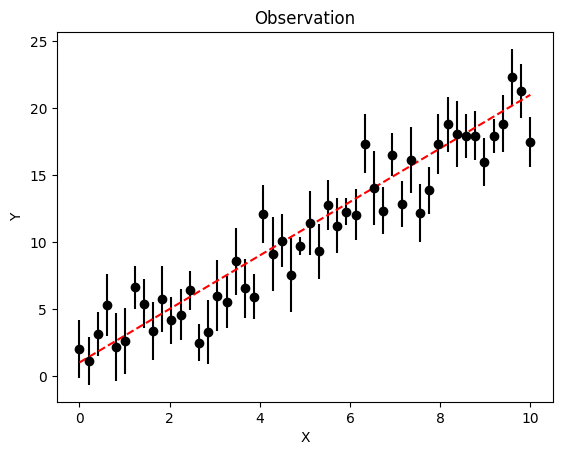

In [5]:
true_param = [true_m,true_b]
plt.title('Observation')
plt.errorbar(x_obs, y_obs, yerr=y_err, color='k', ls=' ', marker='o')
plt.plot(x_obs, model(true_param), color='r', ls='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

As mentioned above, we assume a Gaussian likelihood for this analysis. We also define a flat prior for the parameters of the model. We restrict the explored parameter space to remain within minimum values vector `mins` and maximum values vector `maxs`. 

In [6]:
def log_likelihood(param):
    y_mod = model(param)
    # y_err = 0.5*y_obs
    logL = -np.sum((y_obs-y_mod)**2/2/y_err**2)
    return logL

mins = np.array([-2,-3])
maxs = np.array([6,5])
def log_prior(param):
    m, b = param
    if mins[0]<=m<=maxs[0] and mins[1]<=b<=maxs[1]:
        return 0
    else:
        return -np.inf

def log_probability(param):
    lp = log_prior(param)
    if np.isfinite(lp):
        return lp+log_likelihood(param)
    return -np.inf

In [7]:
print(f'logL({true_param}) =', log_probability(true_param))
param = [0,1]
print(f'logL({param}) =', log_probability(param))
param = [10,1]
print(f'logL({param}) =', log_probability(param))

logL([2, 1]) = -26.545129387851276
logL([0, 1]) = -953.4748879076326
logL([10, 1]) = -inf


### Importance Sampling

[Importance Sampling](https://en.wikipedia.org/wiki/Importance_sampling) is a Monte Carlo method used to evaluate properties of an unknown distribution by using samples generated from a different, known distribution called the proposal distribution. This technique allows us to approximate the target distribution, which in many cases is the posterior distribution of interest, using samples drawn from the proposal distribution.

**Importance Sampling Algorithm Steps:**

We provide the steps along with application to our example case using a implementation of this algorithm in AstronomyCalc.

1. **Define the Target Distribution:**
   - Let \( p(x) \) be the target distribution you wish to sample from. This is often the posterior distribution in a Bayesian context.

In [8]:
def target_distribution(param):
    if np.array(param).ndim==1: return np.exp(log_probability(param))
    else: return np.array([np.exp(log_probability(par)) for par in param])

2. **Choose a Proposal Distribution:**
   - Select a proposal distribution $q(x)$ from which it is easier to draw samples. The proposal distribution should be chosen so that it covers the regions where $p(x)$ has significant mass.
   - A commonly used proposal distribution is a multivariate Gaussian, which used in this AstronomyCalc implementation. 

In [9]:
# Set up the proposal distribution mean and covariance of the Gaussian proposal distribution.
proposal_mean = [2.5, 1.5]
proposal_cov = [[2.0, 1.5], [1.5, 2.0]]

In [10]:
# Initialize the Importance Sampling with default Gaussian proposal
is_sampler = AstronomyCalc.ImportanceSampling(target_distribution, proposal_mean=proposal_mean, proposal_cov=proposal_cov)

3. **Generate Samples:**
   - Draw $N$ independent samples \( $x_1, x_2, \ldots, x_N$ \) from the proposal distribution $q(x)$.

4. **Compute Importance Weights:**
   - For each sample $x_i$, compute the importance weight:

     $w_i = \frac{p(x_i)}{q(x_i)}$.

     These weights represent how much each sample should be "counted" when approximating the target distribution.
   - Normalize the importance weights to sum to 1:

     $\tilde{w}_i = \frac{w_i}{\sum_{j=1}^N w_j}$ .

In [11]:
# Draw samples and compute expectation
samples, weights = is_sampler.sample(n_samples=1000)

6. **Post-Processing**:
   - From sampler, we got the samples \($x_1$, $x_2$, $\ldots$, $x_N$\) and corresponding weights \($w_1$, $w_2$, $\ldots$, $w_N$\) that we can be used to approximate the posterior distribution. 

In [14]:
labels = ['$m$', '$b$']

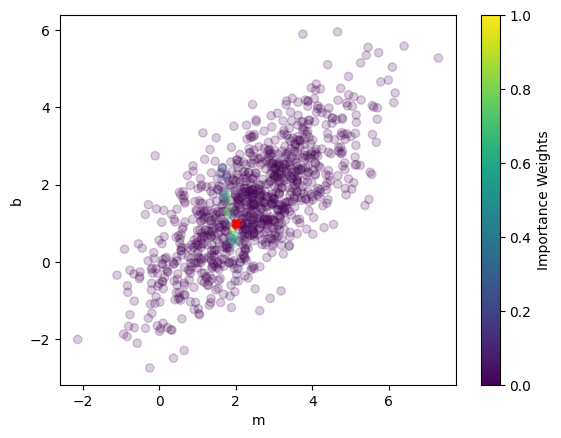

In [12]:
plt.scatter(samples[:, 0], samples[:, 1], c=weights, cmap='viridis', alpha=0.2)
plt.scatter(true_m, true_b, marker='X', color='red')
plt.xlabel('m')
plt.ylabel('b')
plt.colorbar(label='Importance Weights')
plt.show()

(1000, 2)


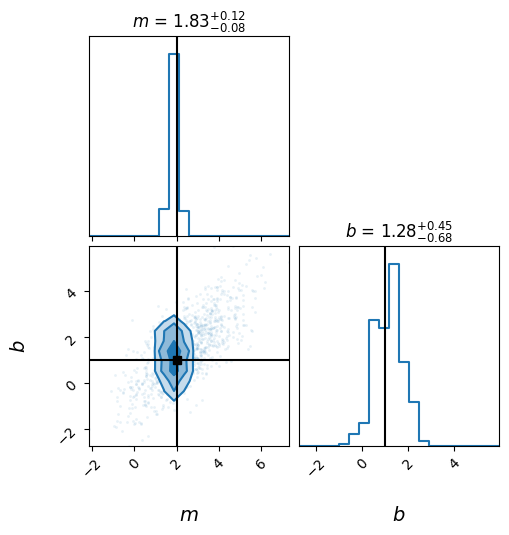

In [15]:
AstronomyCalc.plot_posterior_corner(samples, labels, truths=true_param, weights=weights)

**Notes on Importance Sampling**

While Importance Sampling can effectively approximate the posterior distribution in simpler cases, it becomes inefficient for large and high-dimensional parameter spaces. To address these limitations, several improvements have been developed, such as [Sequential Monte Carlo](https://en.wikipedia.org/wiki/Particle_filter).

In this tutorial, we will also explore another method that converges more effectively to the target distribution.

### Metropolis–Hastings Algorithm

The [Metropolis–Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) is a widely used Markov chain Monte Carlo (MCMC) method for generating a sequence of random samples from a probability distribution, especially when direct sampling is challenging or impossible. This method is particularly valuable in Bayesian statistics, where we often need to sample from complex posterior distributions that cannot be sampled directly.

The key idea behind the Metropolis–Hastings algorithm is to construct a Markov chain whose equilibrium distribution is the target distribution. By running the chain for a sufficient number of iterations, the samples generated will approximate the desired distribution, allowing us to estimate properties such as means, variances, and credible intervals.

**Metropolis-Hastings Algorithm Steps:**

We provide the steps along with application to our example case using a implementation of this algorithm in AstronomyCalc.

1. **Initialize the Chain**:
   - Choose an initial point \($x_0$\) from the state space.
   - Set the initial step to \($n = 0$\).

In [9]:
nwalkers  = 8    #Independent walkers that will sample the distribution.
ndim      = 2    #Dimension of the parameter space
n_samples = 1000 #Total number of samples we want to obtain from each walker

# Setup a sampler
mh_sampler = AstronomyCalc.MetropolisHastings(nwalkers=nwalkers, ndim=ndim, log_probability=log_probability, 
                            proposal_cov=np.eye(ndim), n_jobs=2)

In [10]:
# We randomly initialise the walkers are different locations 
# inside the mininum and maximun ranges of the parameter space
initial_value = np.random.uniform(size=(nwalkers, ndim))*(maxs-mins)+mins 
mh_sampler.initialise(initial_value)

2. **Proposal Step**:
   - Propose a new candidate point \($x^*$\) from a proposal distribution $q(x^* | x_n)$, which suggests a new state based on the current state \($x_n$\).
   - A commonly used proposal distribution is a multivariate Gaussian. We denote a new sample drawn from this distribution as: $x^* \mid x_n \sim \mathcal{N}(x_n, \sigma^2)$, where $\sigma^2$ is the covariance matrix that controls the extent to which we explore from any given position in the parameter space. If $\sigma^2$ is too small, the chain will exhibit slow mixing. This occurs because the acceptance rate might be high, but the chain's successive samples will move very slowly through the space, leading to slow convergence to the target distribution $p(x)$. Conversely, if $\sigma^2$ is too large, the acceptance rate will be very low. This happens because the proposed samples are likely to fall in regions with much lower probability density, resulting in a very small acceptance probability $\alpha$, and hence, slow convergence of the chain.
   - For a Gaussian proposal, the proposal distribution is symmetric, meaning $q(x_n \mid x^*) = q(x^* \mid x_n)$. Therefore, the acceptance probability simplifies to: $\alpha = \min\left(1, \frac{p(x^*)}{p(x_n)}\right)$.

In [11]:
#We assume the covariance of the Gaussian proposal is a diagonal matrix.
proposal_cov = np.eye(ndim) 

print('Drawing new samples from the initial value.')
new_samples = []
for i in range(nwalkers):
    new_sample, q21, q12 = mh_sampler.draw_from_proposal(initial_value[i], proposal_cov)
    print(f'Walker Number {i}: {initial_value[i]} ->', new_sample)
    new_samples.append(new_sample)
new_samples = np.array(new_samples)

Drawing new samples from the initial value.
Walker Number 0: [ 1.33928803 -1.22313752] -> [1.39951824 1.2401046 ]
Walker Number 1: [-1.04107706 -0.29907863] -> [-1.23343803  0.00246871]
Walker Number 2: [ 5.54327763 -0.41437654] -> [ 5.50856586 -1.58305458]
Walker Number 3: [2.15032497 2.62415167] -> [3.29314779 3.3760847 ]
Walker Number 4: [0.90903682 4.77425666] -> [1.70006877 3.86486921]
Walker Number 5: [ 5.69957836 -0.98574163] -> [ 7.10237267 -2.3875927 ]
Walker Number 6: [ 1.97798805 -0.59297352] -> [2.56484514 1.5974821 ]
Walker Number 7: [ 0.27872396 -2.70490442] -> [-0.71181237 -3.27120215]


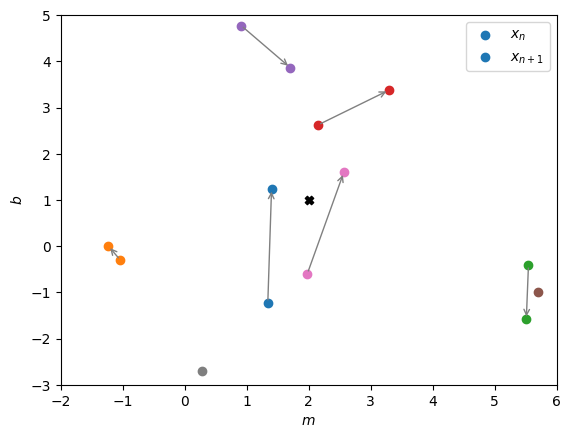

In [12]:
plt.scatter(true_param[0], true_param[1], color='k', marker='X')
for i in range(nwalkers):
    plt.scatter(initial_value[i,0], initial_value[i,1], color=f'C{i}', label='$x_n$' if i==0 else None)
    plt.annotate('', xy=(new_samples[i,0], new_samples[i,1]), xytext=(initial_value[i,0], initial_value[i,1]),
             arrowprops=dict(facecolor='red', edgecolor='grey', arrowstyle='->', lw=1))
    plt.scatter(new_samples[i,0], new_samples[i,1], color=f'C{i}', label='$x_{n+1}$' if i==0 else None)
plt.axis([mins[0],maxs[0],mins[1],maxs[1]])
plt.legend()
plt.xlabel('$m$')
plt.ylabel('$b$')
plt.show()

3. **Acceptance Probability**:
   - Calculate the acceptance probability \( $\alpha$ \) for moving from the current state \($x_n$\) to the proposed state \($x^*$\):
     
      $\alpha = \min\left(1, \frac{p(x^*) \cdot q(x_n | x^*)}{p(x_n) \cdot q(x^* | x_n)}\right)$
     
   - Here, $p(x)$ is the target distribution we want to sample from, and $q(x'|x)$ is the proposal distribution.


In [13]:
p_acc = np.array([mh_sampler.acceptance_probability(initial_value[i], new_samples[i], q21, q12) for i in range(nwalkers)])

4. **Accept or Reject the Proposal**:
   - Generate a random number $u$ from a uniform distribution $U(0, 1)$.
   - If $u \leq \alpha$, accept the proposed state and set $x_{n+1} = x^*$.
   - If $u > \alpha$, reject the proposed state and set $x_{n+1} = x_n$.

In [14]:
u_acc = np.array([np.random.uniform(0,1) for i in range(nwalkers)])
print('Comparing u and a:')
accept_array = []
for i in range(nwalkers):
    accept = (u_acc[i]<=p_acc[i])
    if accept: print(f'Walker Number {i}: {u_acc[i]:.5f} <= {p_acc[i]:.5f}')
    else: print(f'Walker Number {i}: {u_acc[i]:.5f} >  {p_acc[i]:.5f}')
    accept_array.append(accept)

Comparing u and a:
Walker Number 0: 0.04078 <= 1.00000
Walker Number 1: 0.59089 >  0.00000
Walker Number 2: 0.67756 <= 1.00000
Walker Number 3: 0.01659 >  0.00000
Walker Number 4: 0.51209 <= 1.00000
Walker Number 5: 0.22650 >  0.00000
Walker Number 6: 0.64517 >  0.00000
Walker Number 7: 0.17437 >  0.00000


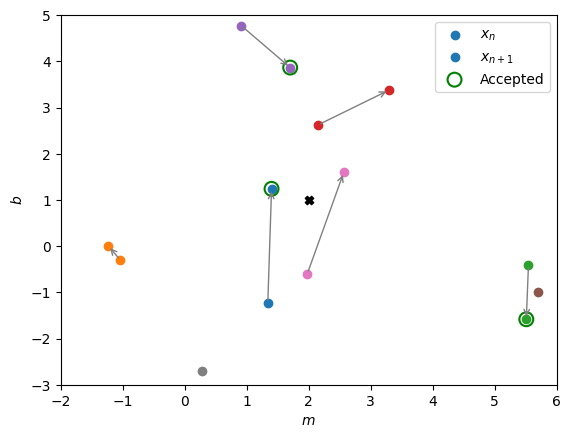

In [15]:
plt.scatter(true_param[0], true_param[1], color='k', marker='X')
for i in range(nwalkers):
    plt.scatter(initial_value[i,0], initial_value[i,1], color=f'C{i}', label='$x_n$' if i==0 else None)
    plt.annotate('', xy=(new_samples[i,0], new_samples[i,1]), xytext=(initial_value[i,0], initial_value[i,1]),
             arrowprops=dict(facecolor='red', edgecolor='grey', arrowstyle='->', lw=1))
    plt.scatter(new_samples[i,0], new_samples[i,1], color=f'C{i}', label='$x_{n+1}$' if i==0 else None)
plt.scatter(new_samples[accept_array,0], new_samples[accept_array,1], 
            edgecolor='green', facecolor='none', s=100, linewidth=1.5, label='Accepted')
plt.axis([mins[0],maxs[0],mins[1],maxs[1]])
plt.legend()
plt.xlabel('$m$')
plt.ylabel('$b$')
plt.show()

5. **Iterate**:
   - Repeat steps 2 to 4 for a large number of iterations to allow the chain to converge to the target distribution.


In [16]:
samples = mh_sampler.run_sampler(n_samples=n_samples, initial_value=initial_value)
print("Samples shape:", samples.shape)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 789.49it/s]

Samples shape: (8, 1000, 2)


6. **Post-Processing**:
   - After running the chain, the samples \($x_1$, $x_2$, $\ldots$, $x_N$\) can be used to approximate the target distribution. Typically, the initial portion of the chain (referred to as the "burn-in" period) is discarded to reduce the impact of the initial state.

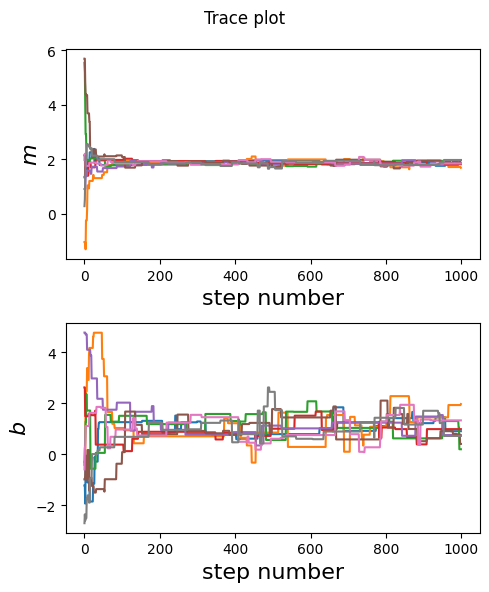

In [17]:
labels = ['$m$', '$b$']

fig, axs = plt.subplots(ndim, 1, figsize=(5,ndim*3))
fig.suptitle('Trace plot')
for i in range(ndim):
    axs[i].set_ylabel(labels[i], fontsize=16)
    axs[i].set_xlabel('step number', fontsize=16)
    for j in range(nwalkers):
        axs[i].plot(samples[j,:,i], c=f'C{j}')
plt.tight_layout()
plt.show()

In [18]:
# We flatten the samples received from all the walkers after removing burn-in
flat_samples = mh_sampler.get_flat_samples(burn_in=10)
print('Flat samples shape:', flat_samples.shape)

Flat samples shape: (7920, 2)


(7920, 2)


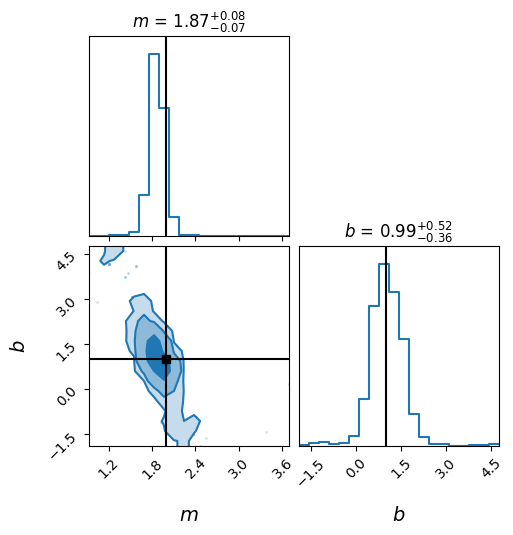

In [19]:
AstronomyCalc.plot_posterior_corner(flat_samples, labels, truths=true_param)

**Notes on Metropolis-Hasting Algorithm**
Here we used a naive implementation of the algorithm. However, there exists sophisticated packages that employ more robust improvements to better explore the parameter space. Few examples of such open-source packages are [emcee](https://emcee.readthedocs.io/en/stable/) and [pyMC](https://www.pymc.io/projects/docs/en/stable/learn.html).

### Inferring cosmological parameters from supernova data

We generate distance modulus data $\mu(z)$ given as,

$\mu(z) = 5\log_{10}\left(\frac{d_L(z)}{1~\mathrm{Mpc}}\right)+25$ ,

where $d_L$ is the luminosity distance estimated by observing supernova. This distance is related to the comoving distance $d_c(z)$ as,

$d_L(z) = (1+z) d_c(z) = (1+z)\frac{c}{H_0}\int\frac{dz}{\left[\Omega_m(1+z)^3+\Omega_\Lambda\right]^{1/2}}$ .

In [18]:
code_param_dict = {'zmin': 0.001, 'zmax': 3.0, 'Nz': 100, 'verbose': True}
cosmo_dict = {'Om': 0.30, 'Or': 0, 'Ok': 0, 'Ode': 0.70, 'h': 0.70}
param = AstronomyCalc.param(cosmo=cosmo_dict, code=code_param_dict)

print('Cosmological parameters')
print(param.cosmo.__dict__)
print('Code parameters')
print(param.code.__dict__)

Cosmological parameters
{'Om': 0.3, 'Or': 0, 'Ok': 0, 'Ode': 0.7, 'h': 0.7, 'Tcmb': 2.725}
Code parameters
{'zmin': 0.001, 'zmax': 3.0, 'Nz': 100, 'verbose': True}


In [43]:
param_true = [67, 0.31, 0.69]
cosmo_true = LambdaCDM(H0=param_true[0], Om0=param_true[1], Ode0=param_true[2])
z_sample, mu_sample, dmu = AstronomyCalc.distance_modulus(cosmo=cosmo_true)
print(z_sample.shape, mu_sample.shape, dmu.shape)

(100,) (100,) (100,)


In [44]:
def model(param):
    cosmo = LambdaCDM(H0=param[0], Om0=param[1], Ode0=param[2])
    zz = np.linspace(0.01, 2, 1000)
    mu = cosmo.distmod(zz)
    return mu, zz

mu_true, z_true = model(param_true)

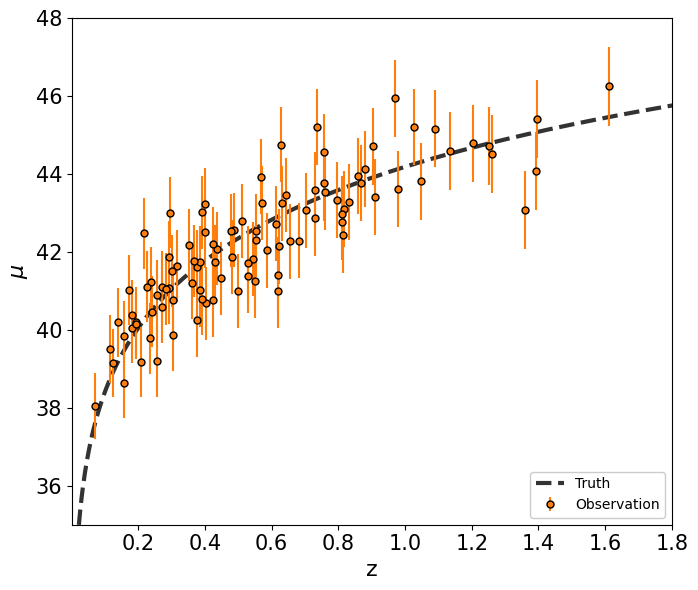

In [45]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.errorbar(z_sample, mu_sample, yerr=dmu,
            ls=' ',
            color='C1',
            marker='o', markeredgecolor='k', markersize=5, 
            label='Observation', zorder=5)
ax.plot(z_true, mu_true, c='k', alpha=0.8, lw=3, ls='--', label='Truth')
ax.legend(loc=4, facecolor='white', framealpha=1)
ax.set_xlabel(r'z', fontsize=16)
ax.set_ylabel(r'$\mu$', fontsize=16)
ax.axis([0.001,1.8,35,48])
ax.tick_params(axis='both', which='major', labelsize=15) 
plt.tight_layout()
plt.show()

In [49]:
from scipy.interpolate import splrep, splev

def log_likelihood(param):
    mu_mod, zz_mod = model(param)
    tck = splrep(zz_mod, mu_mod)
    y_mod = splev(z_sample, tck)
    logL = -np.sum((mu_sample-y_mod)**2/2/dmu**2)
    return logL

mins = np.array([50,0.01,0.50])
maxs = np.array([90,0.60,0.90])
def log_prior(param):
    H0, Om0, Ode0 = param
    if mins[0]<=H0<=maxs[0] and mins[1]<=Om0<=maxs[1] and mins[2]<=Ode0<=maxs[2]:
        return 0
    else:
        return -np.inf

def log_probability(param):
    lp = log_prior(param)
    if np.isfinite(lp):
        return lp+log_likelihood(param)
    return -np.inf

In [50]:
print(f'logL({param_true}) =', log_probability(param_true))
param = [10,0.27,0.73]
print(f'logL({param}) =', log_probability(param))
param = [73,0.31,0.69]
print(f'logL({param}) =', log_probability(param))

logL([67, 0.31, 0.69]) = -41.255338981244286
logL([10, 0.27, 0.73]) = -inf
logL([73, 0.31, 0.69]) = -43.29806975653903


In [51]:
nwalkers = 32
ndim = len(mins)
n_samples = 8000
initial_value = np.random.uniform(size=(nwalkers, ndim))*(maxs-mins)+mins

mh_sampler = AstronomyCalc.MetropolisHastings(nwalkers=nwalkers, ndim=ndim, log_probability=log_probability, 
                        proposal_cov=np.eye(ndim), n_jobs=2)
samples = mh_sampler.run_sampler(n_samples=n_samples, initial_value=initial_value)
print("Samples shape:", samples.shape)

100%|██████████████████████████████████████████████████████████████████████| 8000/8000 [02:53<00:00, 46.15it/s]

Samples shape: (32, 8000, 3)


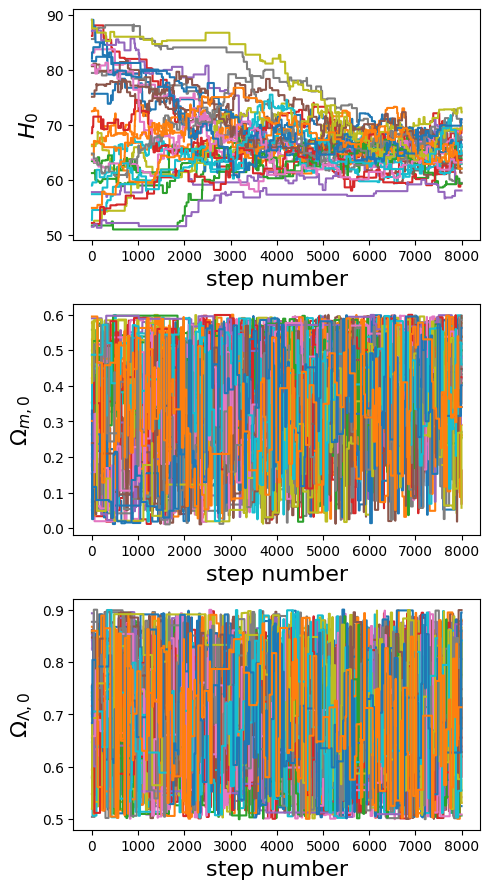

In [52]:
labels = ['$H_0$', '$\Omega_{m,0}$', '$\Omega_{\Lambda,0}$']

fig, axs = plt.subplots(ndim, 1, figsize=(5,ndim*3))
for i in range(ndim):
    axs[i].set_ylabel(labels[i], fontsize=16)
    axs[i].set_xlabel('step number', fontsize=16)
    for j in range(nwalkers):
        axs[i].plot(samples[j,:,i], c=f'C{j}')
plt.tight_layout()
plt.show()

In [53]:
flat_samples = mh_sampler.get_flat_samples(burn_in=100)
print('Flat samples shape:', flat_samples.shape)

Flat samples shape: (252800, 3)


(252800, 3)


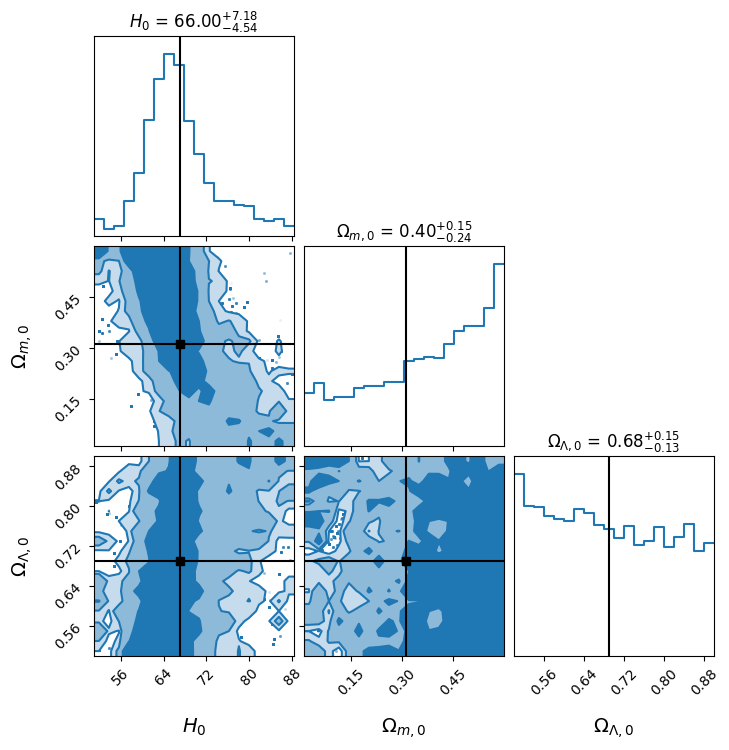

In [54]:
AstronomyCalc.plot_posterior_corner(flat_samples, labels, truths=param_true)